In [1]:
import pandas
import pulp
import geopandas # standard library for geographical data in Python
import numpy # standard library for numerical and array-based computing
import spopt # library for spatial optimisation

In [2]:
postcodes = pandas.read_csv("../uk_postcodes.csv")

# spatialize the data
postcodes = geopandas.GeoDataFrame(
    postcodes, 
    geometry=geopandas.points_from_xy(postcodes.lon, postcodes.lat, crs="epsg:4326")
)

bristol_postcodes = postcodes[postcodes.outward.str.startswith("BS")].copy()

# is the postcode in the center of the city? 
is_inner_city = bristol_postcodes.outward.str.lstrip("BS").astype(int) < 10

# if so, keep it around
bristol_innercity = bristol_postcodes[is_inner_city].copy()

# Do

Now it is time for you to try your hand at solving $p$-Median problems. 

## One again, with feeling

<div class="alert alert-warning">
    
Using the methods we discussed above, can you create a new PMedian problem object to locate eight depots across all Bristol post codes? Are BS6 and BS8 chosen again in this new setup? It may help to make a map using the `.explore()` method. 

</div>

In [3]:
loc8 = spopt.locate.PMedian.from_geodataframe(
    gdf_fac = bristol_postcodes,
    gdf_demand= bristol_postcodes,
    demand_col= "geometry",
    facility_col="geometry",
    weights_cols="demand",
    p_facilities=8
)

In [4]:
solver = pulp.COIN_CMD(msg=False)

In [5]:
loc8.solve(solver)

In [6]:
allocations = numpy.stack(loc8.cli2fac)

In [7]:
allocation_names = bristol_postcodes.outward.values[allocations]

In [8]:
bristol_postcodes.assign(
    allocation=allocation_names.squeeze()
).explore("allocation")

In [9]:
bristol_postcodes.assign(
    allocation=allocation_names.squeeze()
)[
    ['outward', 'geometry', 'demand', 'allocation']
].sort_values("allocation")

,outward,geometry,demand,allocation
264,BS1,POINT (-2.59188 51.46635),119.066167,BS1
303,BS7,POINT (-2.53285 51.48866),76.470352,BS1
302,BS6,POINT (-2.54754 51.46929),104.156384,BS1
301,BS5,POINT (-2.55413 51.46291),74.424220,BS1
298,BS43,POINT (-2.59519 51.44008),99.604888,BS1
297,BS41,POINT (-2.65298 51.42691),86.246961,BS1
295,BS4,POINT (-2.56031 51.43415),102.504517,BS1
286,BS3,POINT (-2.61897 51.42531),115.962676,BS1
305,BS8,POINT (-2.61842 51.45837),116.620348,BS1
275,BS2,POINT (-2.58969 51.45792),95.765799,BS1


## Keep the old solutions around

Unfortunately, between us discovering the first solution for inner-city postcodes and your new work looking at a *all* of Bristol, the depots in BS6 and BS8 were already built. Thus, we need to re-solve the problem for all of Bristol while *ensuring that* BS6 and BS8 are in the solution. We support this in `spopt` using a `predefined_facilities_col` argument. This column should contain `True` when an observation is *must* be selected for the solution, and `False` when it may is allowed to be omitted from the solution. 

In our case, build the column:

```python
bristol_postcodes['preselected'] = bristol_postcodes.outward.isin(("BS6", "BS8"))
```

and use that as the `predefined_facilities_col` argument in `spopt`.

<div class="alert alert-warning">
    
Using the methods we discussed above, can you create a new PMedian problem object to locate eight depots across all Bristol post codes, so that *BS6* and *BS8* are required to be selected as depots? how do the assigments differ between this case and your previous Bristol-wide solution? It may help to make a map using the `.explore()` method. 

</div>

In [10]:
bristol_postcodes['preselected'] = bristol_postcodes.outward.isin(("BS6", "BS8"))

In [11]:
bristol_postcodes.sort_values(
    "preselected", ascending=False
)[['outward', 'geometry', 'demand', 'preselected']].head()

,outward,geometry,demand,preselected
305,BS8,POINT (-2.61842 51.45837),116.620348,True
302,BS6,POINT (-2.54754 51.46929),104.156384,True
264,BS1,POINT (-2.59188 51.46635),119.066167,False
295,BS4,POINT (-2.56031 51.43415),102.504517,False
288,BS31,POINT (-2.49237 51.42438),120.839847,False


In [12]:
loc8_preselected = spopt.locate.PMedian.from_geodataframe(
    gdf_fac = bristol_postcodes,
    gdf_demand= bristol_postcodes,
    predefined_facility_col="preselected",
    demand_col= "geometry",
    facility_col="geometry",
    weights_cols="demand",
    p_facilities=8
)

In [13]:
loc8_preselected.solve(solver)

In [14]:
allocations_forced = numpy.stack(loc8_preselected.cli2fac)
allocation_names_forced = bristol_postcodes.outward.values[allocations_forced]

In [15]:
bristol_postcodes.assign(
    allocation=allocation_names.squeeze(),
    allocation_forced=allocation_names_forced.squeeze()

)[
    ['outward', 'demand', 'allocation', 'allocation_forced']
].sort_values("allocation")

,outward,demand,allocation,allocation_forced
264,BS1,119.066167,BS1,BS8
303,BS7,76.470352,BS1,BS6
302,BS6,104.156384,BS1,BS6
301,BS5,74.424220,BS1,BS6
298,BS43,99.604888,BS1,BS8
297,BS41,86.246961,BS1,BS8
295,BS4,102.504517,BS1,BS6
286,BS3,115.962676,BS1,BS8
305,BS8,116.620348,BS1,BS8
275,BS2,95.765799,BS1,BS8


## Locate depots outside of the city

Land is too expensive in the city. Now, the supervisor wants to make sure that *no* facilities are selected in the city. One way to do this is to use all of the postcodes in *outer Bristol* as facilities, but keep all of the postcodes as demands. To get the postcodes for outer bristol, we invert the selection from inner Bristol:

```python
# in pandas, ~ inverts True/False statements
bristol_outercity = bristol_postcodes[~ is_inner_city].copy()
```

<div class="alert alert-warning">
    
Using the methods we discussed above, can you create a new PMedian problem object to locate eight depots in *outer Bristol* that service *all postcodes in Bristol*? How do the assigments differ between this case and your previous Bristol-wide solution? It may help to make a map using the `.explore()` method. 

</div>

In [16]:
bristol_outercity = bristol_postcodes[~is_inner_city].copy()

In [17]:
loc8_outer = spopt.locate.PMedian.from_geodataframe(
    gdf_fac = bristol_outercity,
    gdf_demand= bristol_postcodes,
    demand_col= "geometry",
    facility_col="geometry",
    weights_cols="demand",
    p_facilities=8
)

In [18]:
loc8_outer.solve(solver)

In [19]:
allocations_outer = numpy.stack(loc8_outer.cli2fac)
allocation_names_outer = bristol_outercity.outward.values[allocations_outer]

In [20]:
bristol_postcodes.assign(
    allocation_outer = allocation_names_outer.squeeze(),
    allocation_free = allocation_names.squeeze(),
)[
    ['outward', 'demand', 'allocation_free', 'allocation_outer']
].sort_values("allocation_free")

,outward,demand,allocation_free,allocation_outer
264,BS1,119.066167,BS1,BS13
303,BS7,76.470352,BS1,BS13
302,BS6,104.156384,BS1,BS13
301,BS5,74.424220,BS1,BS13
298,BS43,99.604888,BS1,BS13
297,BS41,86.246961,BS1,BS13
295,BS4,102.504517,BS1,BS13
286,BS3,115.962676,BS1,BS13
305,BS8,116.620348,BS1,BS13
275,BS2,95.765799,BS1,BS13


Note that all of the located facilities are outside of BS1-BS10, so they're "outer-city" postal codes! 

## **Challenge**: Where to stop? 

In [21]:
from tqdm import trange # this wraps the built-in range function and adds a progressbar

In [22]:
models = [
    spopt.locate.PMedian.from_geodataframe(
        gdf_fac = bristol_postcodes,
        gdf_demand= bristol_postcodes,
        demand_col= "geometry",
        facility_col="geometry",
        weights_cols="demand",
        p_facilities=p
    ).solve(solver)
    for p in trange(1, 21) # remember, range stops at the endpoint!
]

100%|███████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


In [23]:
objective_values = [model.problem.objective.value() for model in models]

Now, if it costs "20" units to open a depot, we can build a vector describing this cost as well. We do not need to include this directly in the optimization problem, since the optimization problem just solves for a solution *given a specific p-value*. 

In [24]:
facility_costs = numpy.arange(1, 21) * 20

In [25]:
facility_costs

array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260,
       280, 300, 320, 340, 360, 380, 400])

Just visualizing the transport costs/objective value from our optimization problem, we see the following solution:

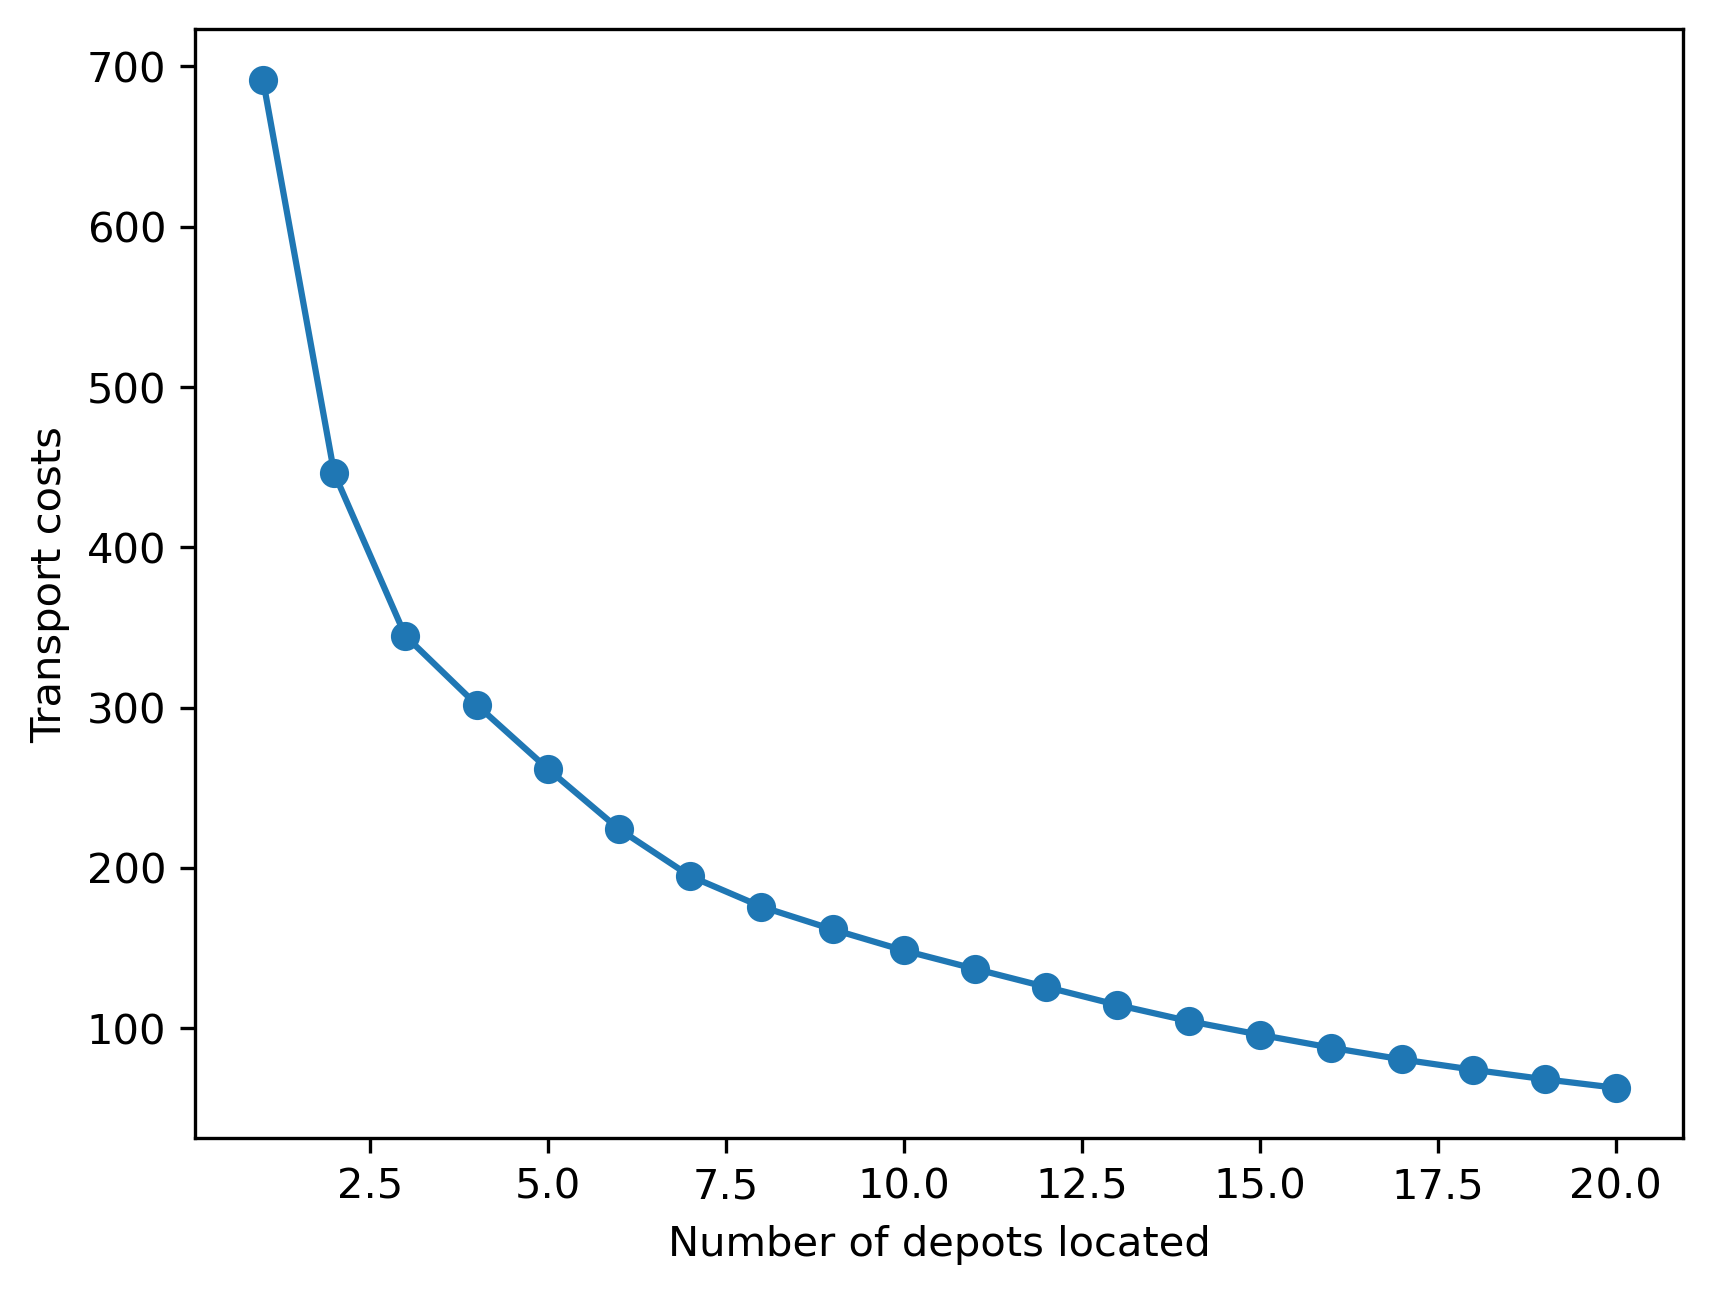

In [26]:
plt.plot(range(1, 21), 
         numpy.asarray(objective_values), 
         marker='o'
        )
plt.xlabel("Number of depots located")
plt.ylabel("Transport costs")
plt.show()

So, going from one depot to three depots halves the cost. Then, moving from three to 9 halves the cost again. To halve the cost further from nine, you'd need nearly 17 depots. Visually, though, it looks like improvements tend to flatten out after around the eighth depot. 

Now, if we include our *facility costs* as a "fixed" cost of opening a depot, we can compute the total cost:

In [27]:
total_cost =  numpy.asarray(objective_values) + facility_costs

And, in this case, you can then find a maximum:

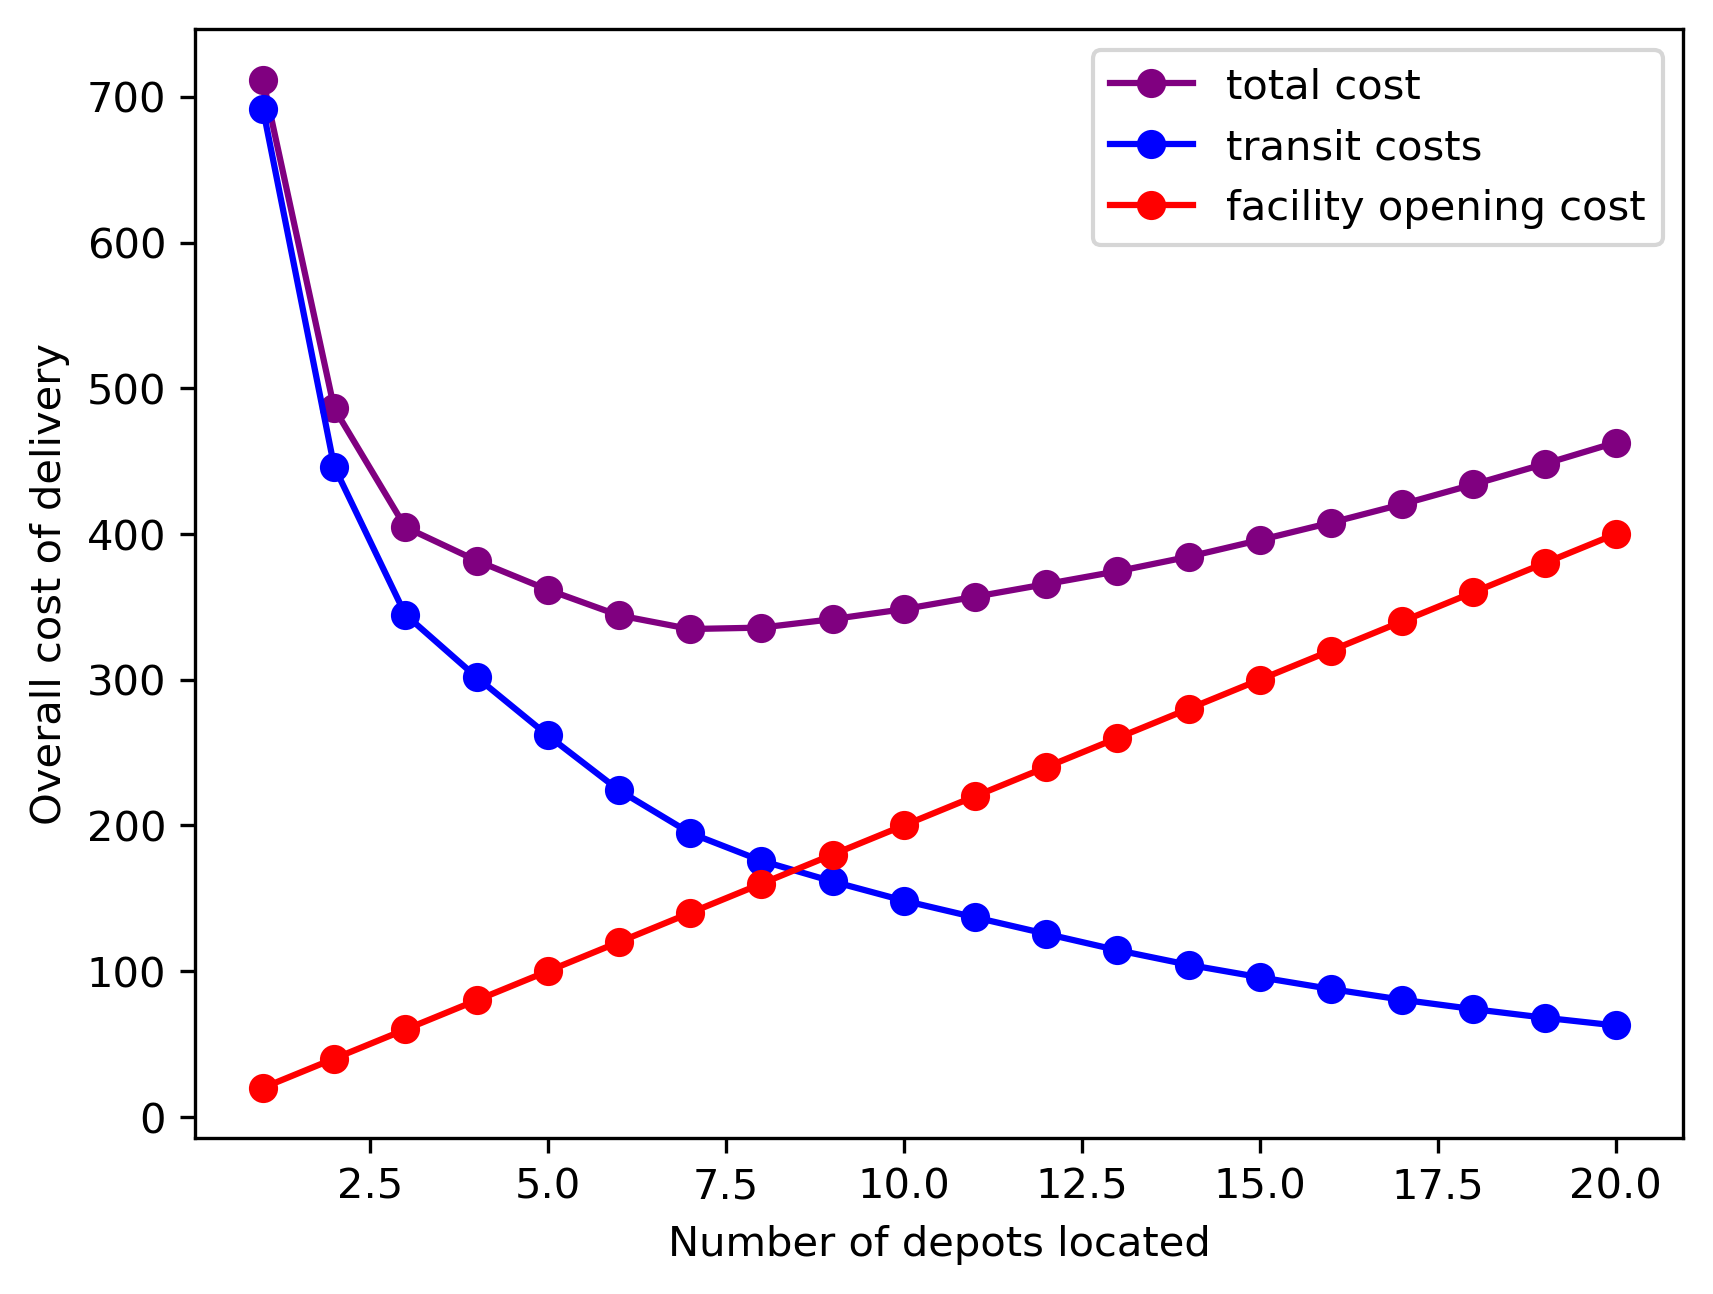

In [28]:
plt.plot(range(1, 21), 
         total_cost, 
         marker='o',
         label='total cost',
         color='purple'
        )
plt.plot(range(1, 21), 
         objective_values, 
         marker='o',
         label='transit costs',
         color='blue'
        )
plt.plot(range(1, 21), 
         facility_costs, 
         marker='o',
         label='facility opening cost',
         color='red'
        )
plt.legend()
plt.xlabel("Number of depots located")
plt.ylabel("Overall cost of delivery")
plt.show()

You can see that costs are minimized at 6 depots, but 8 is also quite low. 